# 9장 - 통제집단합성법



In [7]:
from toolz.curried import *


import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

## 9.1 온라인 마케팅 데이터셋


In [8]:
import pandas as pd
import numpy as np

df = (pd.read_csv("./data/online_mkt.csv")
      .astype({"date":"datetime64[ns]"}))

df.head()

,app_download,population,city,state,date,post,treated
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1


In [9]:
treated = list(df.query("treated==1")["city"].unique())
treated

['sao_paulo', 'porto_alegre', 'joao_pessoa']

In [10]:
df_norm = df.assign(
    app_download_pct = 100*df["app_download"]/df["population"]
)

df_norm.head()

,app_download,population,city,state,date,post,treated,app_download_pct
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1,0.024733
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1,0.021789
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1,0.015545
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1,0.011705
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1,0.010067


In [11]:
tr_period = df_norm.query("post==1")["date"].min() #언제 캠페인을 시작하였는지 확인
tr_period

Timestamp('2022-05-01 00:00:00')

Text(0, 0.5, 'app_download_pct')

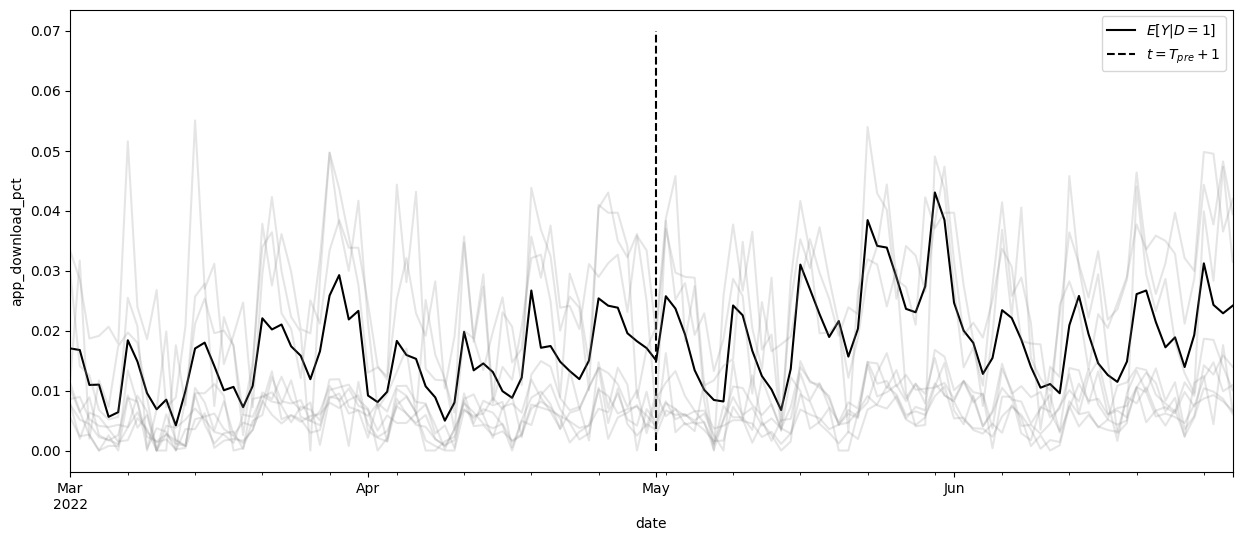

In [13]:
np.random.seed(123)

df_sc = df_norm.pivot(index="date", columns="city",values= "app_download_pct")

ax = df_sc[treated].mean(axis=1).plot(figsize=(15,6), label="$E[Y|D=1]$")
ax.vlines(tr_period, 0, 0.07, ls="dashed", label="$t=T_{pre}+1$")
ax.legend()
df_sc.drop(columns=treated).sample(frac=0.2, axis=1).plot(color="0.5", alpha=0.2, legend=False, ax=ax)
plt.ylabel("app_download_pct")

## 9.2 행렬 표현


In [16]:
def reshape_sc_data(df: pd.DataFrame,
                    geo_col: str, 
                    time_col: str,
                    y_col: str,
                    tr_geos: str,
                    tr_start: str):
    
    df_pivot = df.pivot(index=time_col,columns= geo_col,values= y_col)
    
    y_co = df_pivot.drop(columns=tr_geos)
    y_tr = df_pivot[tr_geos]
    
    y_pre_co = y_co[df_pivot.index < tr_start]
    y_pre_tr = y_tr[df_pivot.index < tr_start]
    
    y_post_co = y_co[df_pivot.index >= tr_start]
    y_post_tr = y_tr[df_pivot.index >= tr_start]
    
    return y_pre_co, y_pre_tr, y_post_co, y_post_tr

In [17]:
y_pre_co, y_pre_tr, y_post_co, y_post_tr = reshape_sc_data(
    df_norm,
    geo_col="city",
    time_col="date",
    y_col="app_download_pct",
    tr_geos=treated,
    tr_start=str(tr_period)
)

y_pre_tr.head()

city,sao_paulo,porto_alegre,joao_pessoa
date,,,
2022-03-01,0.024733,0.004288,0.022039
2022-03-02,0.021789,0.008107,0.020344
2022-03-03,0.015545,0.004891,0.012352
2022-03-04,0.011705,0.002948,0.018285
2022-03-05,0.010067,0.006767,0.000000


## 9.3 통제집단합성법과 수평 회귀분석


In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(y_pre_co, y_pre_tr.mean(axis=1))

# extract the weights
weights_lr = model.coef_
weights_lr.round(3)

array([-0.65 , -0.058, -0.239,  0.971,  0.03 , -0.204,  0.007,  0.095,
        0.102,  0.106,  0.074,  0.079,  0.032, -0.5  , -0.041, -0.154,
       -0.014,  0.132,  0.115,  0.094,  0.151, -0.058, -0.353,  0.049,
       -0.476, -0.11 ,  0.158, -0.002,  0.036, -0.129, -0.066,  0.024,
       -0.047,  0.089, -0.057,  0.429,  0.23 , -0.086,  0.098,  0.351,
       -0.128,  0.128, -0.205,  0.088,  0.147,  0.555,  0.229])

In [10]:
# same as y0_tr_hat = model.predict(y_post_co)
y0_tr_hat = y_post_co.dot(weights_lr)

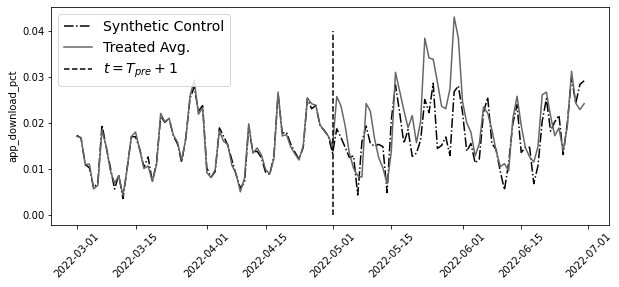

In [11]:
plt.figure(figsize=(10,4))

y_co = pd.concat([y_pre_co, y_post_co])
y_tr = pd.concat([y_pre_tr, y_post_tr])


plt.plot(y_co.index, model.predict(y_co), label="Synthetic Control", ls="-.")
plt.plot(y_tr.mean(axis=1), label="Treated Avg.")
plt.vlines(pd.to_datetime("2022-05-01"), 0, 0.04, ls="dashed", label="$t=T_{pre}+1$")
plt.xticks(rotation=45)
plt.ylabel("app_download_pct")
plt.legend(fontsize=14)

In [12]:
att = y_post_tr.mean(axis=1) - y0_tr_hat

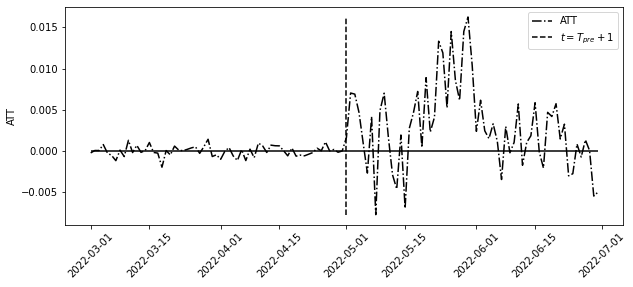

In [13]:
plt.figure(figsize=(10,4))
plt.plot(y_tr.mean(axis=1) - model.predict(y_co), label="ATT", ls="-.")
plt.vlines(pd.to_datetime("2022-05-01"), att.min(), att.max(), ls="dashed", label="$t=T_{pre}+1$")
plt.hlines(0, y_tr.index.min(), y_tr.index.max())
plt.ylabel("ATT")
plt.xticks(rotation=45)
plt.legend()


## 9.4 표준 통제집단합성법


In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (check_X_y, check_array,
                                      check_is_fitted)
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, y_pre_co, y_pre_tr):

        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)
    
        w = cp.Variable(y_pre_co.shape[1])
        
        objective = cp.Minimize(cp.sum_squares(y_pre_co@w - y_pre_tr))
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        
        self.loss_ = problem.solve(verbose=False)
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, y_co):

        check_is_fitted(self)
        y_co = check_array(y_co)
        
        return y_co @ self.w_

In [15]:
model = SyntheticControl()
model.fit(y_pre_co, y_pre_tr.mean(axis=1))

# extrac the weights
model.w_.round(3)

array([-0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.076,  0.037,
        0.083,  0.01 , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        0.061,  0.123,  0.008,  0.074, -0.   ,  0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   , -0.   ,  0.092,
       -0.   , -0.   ,  0.   ,  0.046,  0.089,  0.   ,  0.067,  0.061,
        0.   , -0.   , -0.   ,  0.088,  0.   ,  0.086, -0.   ])

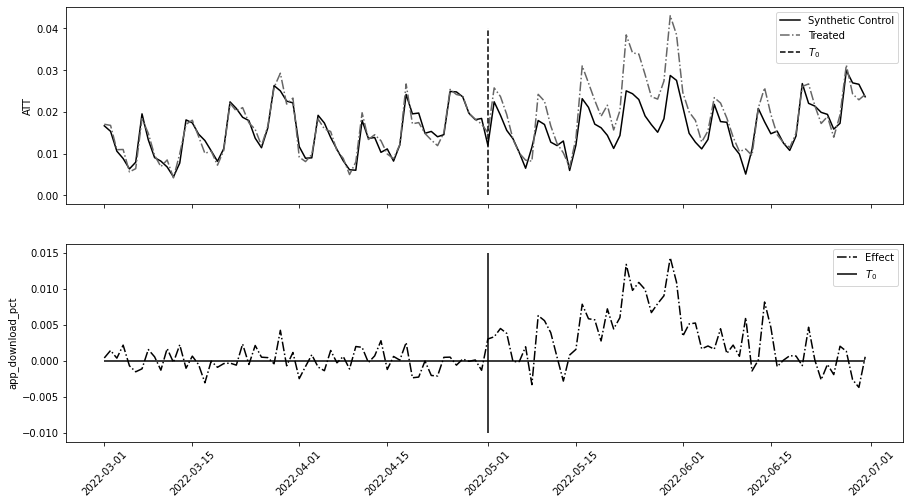

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True)

ax1.plot(y_co.index, model.predict(y_co), label="Synthetic Control")
ax1.plot(y_tr.mean(axis=1), label="Treated", ls="-.")
ax1.vlines(pd.to_datetime("2022-05-01"), 0, 0.04, ls="dashed", label="$T_0$")
ax1.legend()
ax1.set_ylabel("ATT")

ax2.plot(y_co.index, y_tr.mean(axis=1) - model.predict(y_co), label="Effect", ls="-.")
ax2.hlines(0, y_co.index.min(), y_co.index.max())
ax2.vlines(pd.to_datetime("2022-05-01"), -0.01, 0.015, label="$T_0$")
ax2.legend()
ax2.set_ylabel("app_download_pct")

plt.xticks(rotation=45);

## 9.5 통제집단합성법과 공변량

In [17]:
df_norm_cov = (pd.read_csv("./data/online_mkt_cov.csv")
               .astype({"date":"datetime64[ns]"}))

df_norm_cov.head()

,app_download,population,city,state,date,post,treated,app_download_pct,comp_download_pct
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1,0.024733,0.026280
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1,0.021789,0.023925
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1,0.015545,0.018930
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1,0.011705,0.015858
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1,0.010067,0.014548


In [18]:
from toolz import partial

reshaper = partial(reshape_sc_data,
                   df=df_norm_cov,
                   geo_col="city",
                   time_col="date",
                   tr_geos=treated,
                   tr_start=str(tr_period))

y_pre_co, y_pre_tr, y_post_co, y_post_tr = reshaper(
    y_col="app_download_pct"
)

x_pre_co, _, x_post_co, _ = reshaper(y_col="comp_download_pct")

In [19]:
def find_w_given_vs(vs, x_co_list, y_tr_pre):
    X_times_v = sum([x*v for x, v in zip(x_co_list, vs)])
    
    model = SyntheticControl()
    model.fit(X_times_v, y_tr_pre)
    
    return {"loss": model.loss_, "w": model.w_} 


find_w_given_vs([1, 0],
                [y_pre_co, x_pre_co],
                y_pre_tr.mean(axis=1)).get("w").round(3)

array([-0.   , -0.   ,  0.   , -0.   , -0.   , -0.   ,  0.084,  0.039,
        0.085,  0.003, -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   ,
        0.062,  0.121, -0.   ,  0.072, -0.   ,  0.   , -0.   ,  0.   ,
       -0.   , -0.   ,  0.   , -0.   , -0.   ,  0.   , -0.   ,  0.095,
        0.   , -0.   ,  0.   ,  0.022,  0.116, -0.   ,  0.068,  0.046,
       -0.   , -0.   , -0.   ,  0.088,  0.   ,  0.098, -0.   ])

In [20]:
from scipy.optimize import minimize

def v_loss(vs):
    return find_w_given_vs(vs,
                           [y_pre_co, x_pre_co],
                           y_pre_tr.mean(axis=1)).get("loss")


v_solution = minimize(v_loss, [0, 0], method='L-BFGS-B')
v_solution.x

array([1.88034589, 0.00269853])

In [21]:
w_cov = find_w_given_vs(v_solution.x,
                        [y_pre_co, x_pre_co],
                        y_pre_tr.mean(axis=1)).get("w").round(3)

w_cov

array([-0.   , -0.   ,  0.   , -0.   , -0.   , -0.   ,  0.078,  0.001,
        0.033,  0.   , -0.   ,  0.034, -0.   , -0.   , -0.   ,  0.   ,
        0.016,  0.047,  0.03 ,  0.01 , -0.   , -0.   ,  0.   ,  0.055,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.046,
        0.078,  0.007,  0.   ,  0.   ,  0.138,  0.   ,  0.022,  0.008,
       -0.   ,  0.201,  0.   ,  0.035,  0.   ,  0.161, -0.   ])

In [22]:
y0_hat = sum([x*v for x, v 
              in zip([y_post_co, x_post_co], v_solution.x)]).dot(w_cov)

att = y_post_tr.mean(axis=1) - y0_hat

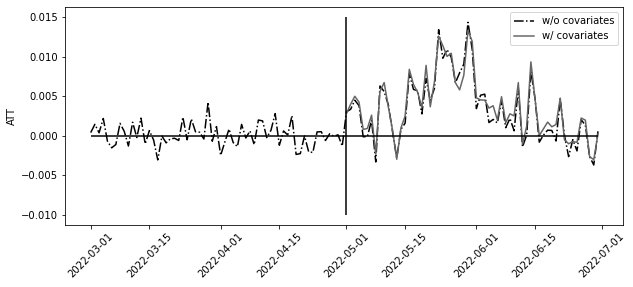

In [23]:
plt.figure(figsize=(10,4))
plt.plot(y_co.index, y_tr.mean(axis=1) - model.predict(y_co), label="w/o covariates", ls="-.")
plt.plot(att.index, att, label="w/ covariates")


plt.hlines(0, y_co.index.min(), y_co.index.max())
plt.vlines(pd.to_datetime("2022-05-01"), -0.01, 0.015)
plt.legend()
plt.ylabel("ATT")
plt.xticks(rotation=45);

## 9.6 통제집단합성법과 편향 제거


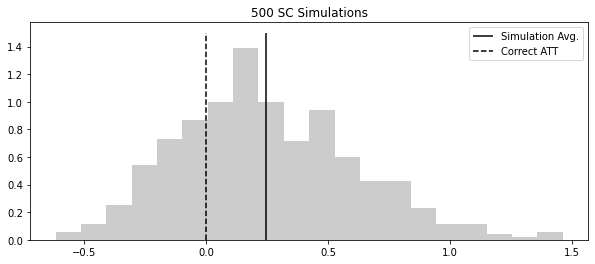

In [24]:
from statsmodels.tsa.arima_process import ArmaProcess

def sim_sc_data(N=16, T0=15, T1=28):
    Y_co = np.random.normal(
        np.array([np.concatenate([np.ones(3), np.zeros(N-3)])*2 for _ in range(T0+T1)])
    )
    
    w = np.concatenate([np.ones(3), np.zeros(N-3)])*1/3
    Y_tr = Y_co.dot(w) + ArmaProcess(0.8).generate_sample(T0+T1)
    
    model = SyntheticControl().fit(
        y_pre_co=Y_co[:T0],
        y_pre_tr=Y_tr[:T0].flatten()
    )
        
    return (Y_tr[T0:].flatten() - model.predict(Y_co[T0:])).mean()


np.random.seed(123)

atts = [sim_sc_data() for _ in range(500)]

plt.figure(figsize=(10,4))
plt.hist(atts, alpha=0.2, density=True, bins=20)
plt.vlines(np.mean(atts), 0, 1.5, label="Simulation Avg.")
plt.vlines(0, 0, 1.5, label="Correct ATT", ls="dashed")
plt.title("500 SC Simulations")
plt.legend()

In [25]:
def debiased_sc_atts(y_pre_co, y_pre_tr, y_post_co, y_post_tr, K=3):
        
    block_size = int(min(np.floor(len(y_pre_tr)/K), len(y_post_tr)))
    blocks = np.split(y_pre_tr.index[-K*block_size:], K)
    
    def fold_effect(hold_out):
        model = SyntheticControl()
        model.fit(
            y_pre_co.drop(hold_out),
            y_pre_tr.drop(hold_out)
        )
        
        bias_hat = np.mean(y_pre_tr.loc[hold_out]
                           - model.predict(y_pre_co.loc[hold_out]))
        
        y0_hat = model.predict(y_post_co)
        return (y_post_tr - y0_hat) - bias_hat
    
    
    return pd.DataFrame([fold_effect(block) for block in blocks]).T

In [26]:
deb_atts = debiased_sc_atts(y_pre_co,
                            y_pre_tr.mean(axis=1),
                            y_post_co,
                            y_post_tr.mean(axis=1),
                            K=3)

deb_atts.head()

,0,1,2
date,,,
2022-05-01,0.003314,0.002475,0.003322
2022-05-02,0.003544,0.002844,0.003355
2022-05-03,0.004644,0.003698,0.004743
2022-05-04,0.004706,0.002866,0.003675
2022-05-05,0.000134,-0.000541,0.000315


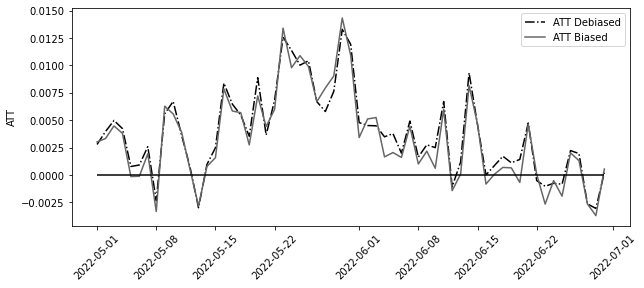

In [27]:
model_biased = SyntheticControl()
model_biased.fit(y_pre_co, y_pre_tr.mean(axis=1))

att_biased = y_post_tr.mean(axis=1) - model_biased.predict(y_post_co)

plt.figure(figsize=(10,4))
plt.plot(att, label="ATT Debiased", ls="-.")
plt.plot(att_biased, label="ATT Biased")
plt.legend()
plt.hlines(0, att.index.min(), att.index.max())
plt.ylabel("ATT")
plt.xticks(rotation=45);


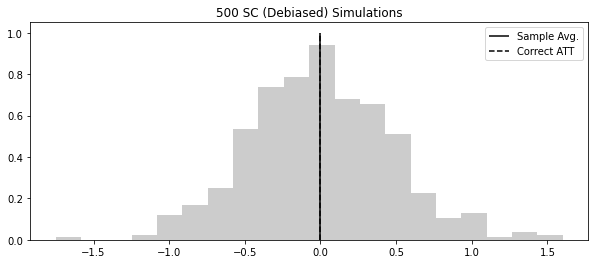

In [28]:
def sim_deb_sc_data(N=16, T0=15, T1=28):
    Y_co = np.random.normal(
        np.array([np.concatenate([np.ones(3), np.zeros(N-3)])*2 for _ in range(T0+T1)])
    )
    
    w = np.concatenate([np.ones(3), np.zeros(N-3)])*1/3
    Y_tr = Y_co.dot(w) + ArmaProcess(0.8).generate_sample(T0+T1)
    
    df_co = pd.DataFrame(Y_co)
    df_tr = pd.DataFrame(Y_tr)
    
    atts = debiased_sc_atts(df_co.iloc[:T0],
                            df_tr.iloc[:T0].mean(axis=1),
                            df_co.iloc[T0:],
                            df_tr.iloc[T0:].mean(axis=1), K=2)
    
        
    return atts.mean(axis=0).mean()


np.random.seed(123)
atts = [sim_deb_sc_data() for _ in range(500)]

plt.figure(figsize=(10,4))
plt.hist(atts, alpha=0.2, density=True, bins=20)
plt.vlines(np.mean(atts), 0, 1.0, label="Sample Avg.")
plt.vlines(0, 0, 1, label="Correct ATT", ls="dashed")
plt.title("500 SC (Debiased) Simulations")
plt.legend()


## 9.7 추론


In [29]:
deb_atts.head()

,0,1,2
date,,,
2022-05-01,0.003314,0.002475,0.003322
2022-05-02,0.003544,0.002844,0.003355
2022-05-03,0.004644,0.003698,0.004743
2022-05-04,0.004706,0.002866,0.003675
2022-05-05,0.000134,-0.000541,0.000315


In [30]:
atts_k = deb_atts.mean(axis=0).values
att = np.mean(atts_k)

print("atts_k:", atts_k)
print("ATT:", att)

atts_k: [0.00414872 0.00260513 0.00322101]
ATT: 0.003324950193632595


In [31]:
K = len(atts_k)
T0 = len(y_pre_co)
T1 = len(y_post_co)
block_size = min(np.floor(T0/K), T1)

se_hat=np.sqrt(1+((K*block_size)/T1))*np.std(atts_k, ddof=1)/np.sqrt(K)

print("SE:", se_hat)

SE: 0.0006318346108228888


In [32]:
from scipy.stats import t
alpha = 0.1

[att - t.ppf(1-alpha/2, K-1)*se_hat,
 att + t.ppf(1-alpha/2, K-1)*se_hat]

[0.0014800022408602205, 0.005169898146404969]

## 9.8 합성 이중차분법

### 9.8.1 이중차분법 복습


### 9.8.2 통제집단합성법 복습



In [33]:
sc_model = SyntheticControl()
sc_model.fit(y_pre_co, y_pre_tr.mean(axis=1))

(y_post_tr.mean(axis=1) - sc_model.predict(y_post_co)).mean()

0.003327040979396121

In [34]:
unit_w = pd.DataFrame(zip(y_pre_co.columns, sc_model.w_),
                         columns=["city", "unit_weight"])

unit_w.head()

,city,unit_weight
0,ananindeua,-0.000008
1,aparecida_de_goiania,-0.000001
2,aracaju,-0.000008
3,belem,-0.000012
4,belford_roxo,-0.000006


In [35]:
pd.set_option('display.max_columns', 7)

In [36]:
df_with_w = (df_norm
             .assign(tr_post = lambda d: d["post"]*d["treated"])
             .merge(unit_w, on=["city"], how="left")
             .fillna({"unit_weight": df_norm["treated"].mean()}))
             
df_with_w.head()

,app_download,population,city,...,app_download_pct,tr_post,unit_weight
0,3066.0,12396372,sao_paulo,...,0.024733,0,0.06
1,2701.0,12396372,sao_paulo,...,0.021789,0,0.06
2,1927.0,12396372,sao_paulo,...,0.015545,0,0.06
3,1451.0,12396372,sao_paulo,...,0.011705,0,0.06
4,1248.0,12396372,sao_paulo,...,0.010067,0,0.06


In [37]:
mod = smf.wls(
    "app_download_pct ~ tr_post + C(date)",
    data=df_with_w.query("unit_weight>=1e-10"),
    weights=df_with_w.query("unit_weight>=1e-10")["unit_weight"]
)

mod.fit().params["tr_post"]

0.0033293800074678703

### 9.8.3 시간 가중치 추정하기


In [38]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self, fit_intercept=False):
        self.fit_intercept = fit_intercept

    def fit(self, y_pre_co, y_pre_tr):

        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)
        
        # add intercept
        intercept = np.ones((y_pre_co.shape[0], 1))*self.fit_intercept
        X = np.concatenate([intercept, y_pre_co], axis=1)
        w = cp.Variable(X.shape[1])
        
        objective = cp.Minimize(cp.sum_squares(X@w - y_pre_tr))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        
        problem = cp.Problem(objective, constraints)
        
        self.loss_ = problem.solve(verbose=False)
        self.w_ = w.value[1:] # remove intercept
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, y_co):

        check_is_fitted(self)
        y_co = check_array(y_co)
        
        return y_co @ self.w_

In [39]:
time_sc = SyntheticControl(fit_intercept=True)

time_sc.fit(
    y_pre_co.T,
    y_post_co.mean(axis=0)
)

time_w = pd.DataFrame(zip(y_pre_co.index, time_sc.w_),
                         columns=["date", "time_weight"])

time_w.tail()

,date,time_weight
56,2022-04-26,-0.000011
57,2022-04-27,0.071965
58,2022-04-28,-0.000002
59,2022-04-29,0.078350
60,2022-04-30,0.000002


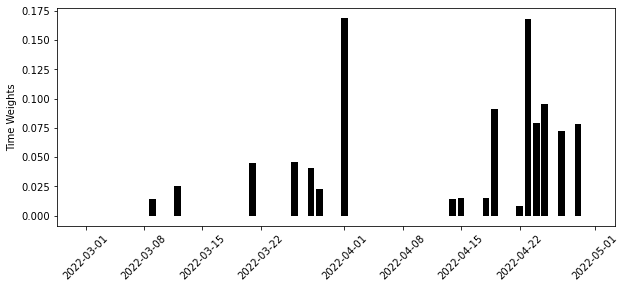

In [40]:

plt.figure(figsize=(10,4))
plt.bar(time_w["date"], time_w["time_weight"])
plt.ylabel("Time Weights")
plt.xticks(rotation=45);

### 9.8.4 통제집단합성법과 이중차분법


In [41]:
scdid_df = (
    df_with_w
    .merge(time_w, on=["date"], how="left")
    .fillna({"time_weight":df_norm["post"].mean()})
    .assign(weight = lambda d: (d["time_weight"]*d["unit_weight"]))
)

In [42]:
did_model = smf.wls(
    "app_download_pct ~ treated*post",
    data=scdid_df.query("weight>1e-10"),
    weights=scdid_df.query("weight>1e-10")["weight"]).fit()

did_model.params["treated:post"]

0.004086196404101931

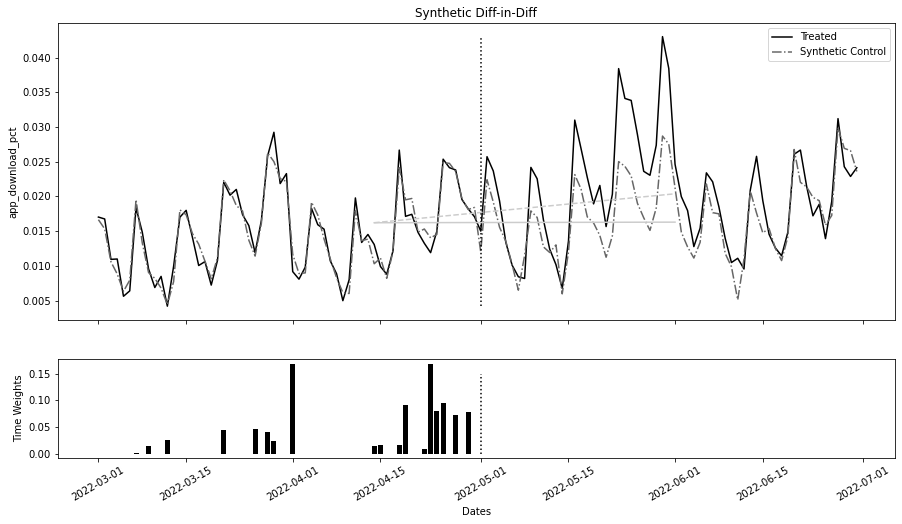

In [43]:
avg_pre_period = time_w.iloc[int((time_w["time_weight"] * np.arange(0, len(time_w), 1)).sum().round())]["date"]
avg_post_period = pd.Timestamp("2022-06-01")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(y_co.index, y_tr.mean(axis=1), label="Treated")
ax1.plot(y_co.index, sc_model.predict(y_co), label="Synthetic Control", ls="-.")
ax1.vlines(tr_period, y_tr.mean(axis=1).min(), y_tr.mean(axis=1).max(), color="black", ls="dotted")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["post"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["treated:post"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")
ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("app_download_pct")

ax2.bar(time_w["date"], time_w["time_weight"])
ax2.vlines(tr_period, 0, 0.15, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Dates")
plt.xticks(rotation=30);


## 9.9 요약
